In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot


from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, GRU, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

dynamic_1 = np.where(trainy == 0)[0]
dynamic_2 = np.where(trainy == 1)[0]
dynamic_3 = np.where(trainy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic)

trainX = X_train_all[dynamic]
trainy = y_train_all[dynamic]

<ipython-input-9-c62d2340b2f3>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [10]:
dynamic_1 = np.where(testy == 0)[0]
dynamic_2 = np.where(testy == 1)[0]
dynamic_3 = np.where(testy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic_list)

testX = X_test_all[dynamic]
testy = y_test_all[dynamic]

<ipython-input-10-7edbb04a2a02>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]]


In [12]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (3285, 128, 9)
Y train shape:  (3285, 1)
Y train One hot shape:  (3285, 3)
X test shape:  (1387, 128, 9)
Y test shape:  (1387, 1)
Y test One hot shape:  (1387, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# GRU1

In [16]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               106752    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 140035 (547.01 KB)
Trainable params: 140035 (547.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 15s 92ms/step - loss: 1.0595 - accuracy: 0.4262 - val_loss: 1.0017 - val_accuracy: 0.5304
Epoch 2/10
26/26 [==============================] - 1s 27ms/step - loss: 0.9589 - accuracy: 0.5364 - val_loss: 0.8690 - val_accuracy: 0.6187
Epoch 3/10
26/26 [==============================] - 1s 32ms/step - loss: 0.7952 - accuracy: 0.6365 - val_loss: 0.6318 - val_accuracy: 0.7383
Epoch 4/10
26/26 [==============================] - 1s 23ms/step - loss: 0.5325 - accuracy: 0.7769 - val_loss: 0.3802 - val_accuracy: 0.8377
Epoch 5/10
26/26 [==============================] - 1s 33ms/step - loss: 0.3337 - accuracy: 0.8676 - val_loss: 0.1919 - val_accuracy: 0.9310
Epoch 6/10
26/26 [==============================] - 1s 28ms/step - loss: 0.1602 - accuracy: 0.9416 - val_loss: 0.1025 - val_accuracy: 0.9655
Epoch 7/10
26/26 [==============================] - 1s 27ms/step - loss: 0.0758 - accuracy: 0.9756 - val_loss: 0.0434 - val_accuracy: 0.9828
Epoch 8/10
2

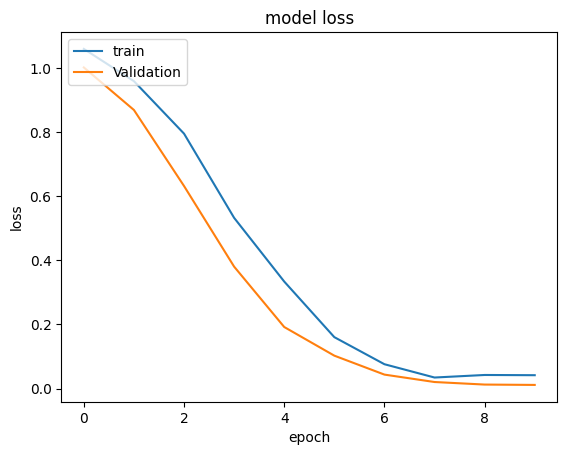

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

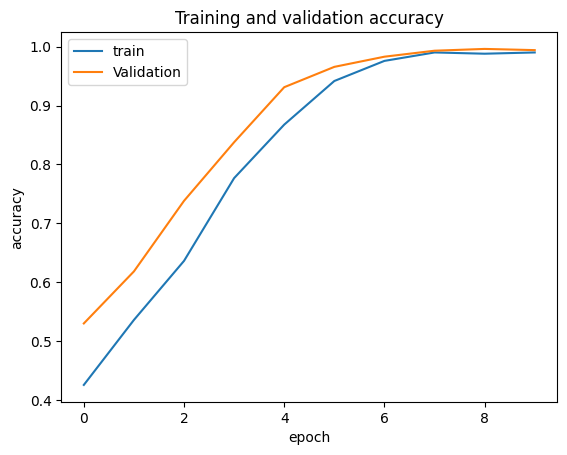

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 2s 9ms/step
[[452  21  23]
 [ 19 440  12]
 [  3   5 412]]
0.9401586157173756
0.9399920803567684
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       496
           1       0.94      0.93      0.94       471
           2       0.92      0.98      0.95       420

    accuracy                           0.94      1387
   macro avg       0.94      0.94      0.94      1387
weighted avg       0.94      0.94      0.94      1387



<Axes: >

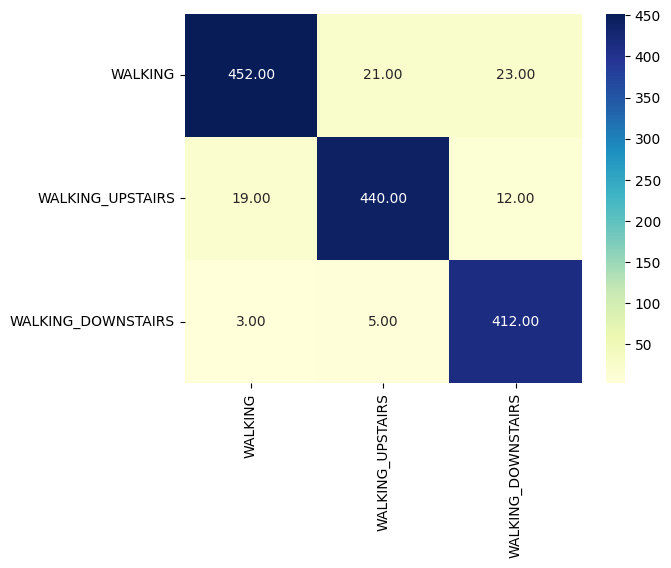

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 2


In [21]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 3)                

In [22]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 9s 110ms/step - loss: 1.0428 - accuracy: 0.4518 - val_loss: 0.9387 - val_accuracy: 0.6004
Epoch 2/10
26/26 [==============================] - 1s 39ms/step - loss: 0.8969 - accuracy: 0.5784 - val_loss: 0.7676 - val_accuracy: 0.6775
Epoch 3/10
26/26 [==============================] - 1s 41ms/step - loss: 0.6936 - accuracy: 0.7065 - val_loss: 0.4219 - val_accuracy: 0.8408
Epoch 4/10
26/26 [==============================] - 1s 37ms/step - loss: 0.3125 - accuracy: 0.8919 - val_loss: 0.1610 - val_accuracy: 0.9473
Epoch 5/10
26/26 [==============================] - 1s 37ms/step - loss: 0.1115 - accuracy: 0.9686 - val_loss: 0.0509 - val_accuracy: 0.9848
Epoch 6/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0436 - accuracy: 0.9860 - val_loss: 0.0113 - val_accuracy: 0.9970
Epoch 7/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0253 - accuracy: 0.9912 - val_loss: 0.0160 - val_accuracy: 0.9959
Epoch 8/10
2

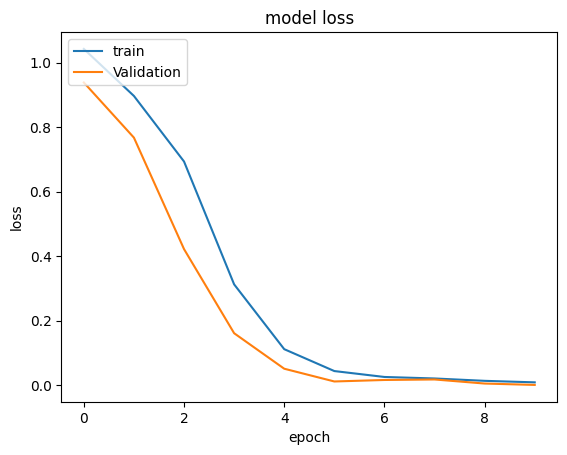

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

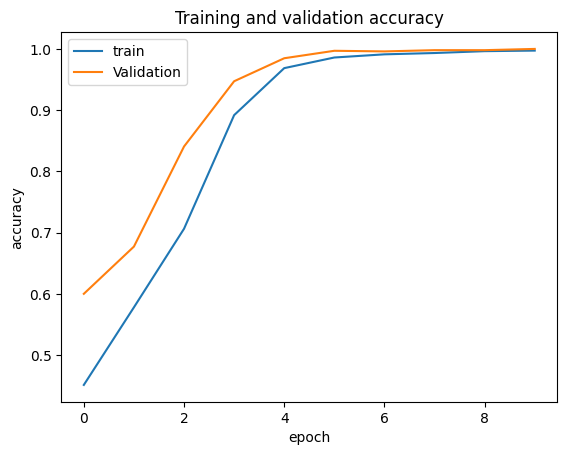

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 8ms/step
[[467   5  24]
 [ 17 449   5]
 [  1   5 414]]
0.958904109589041
0.9589015414947438
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       496
           1       0.98      0.95      0.97       471
           2       0.93      0.99      0.96       420

    accuracy                           0.96      1387
   macro avg       0.96      0.96      0.96      1387
weighted avg       0.96      0.96      0.96      1387



<Axes: >

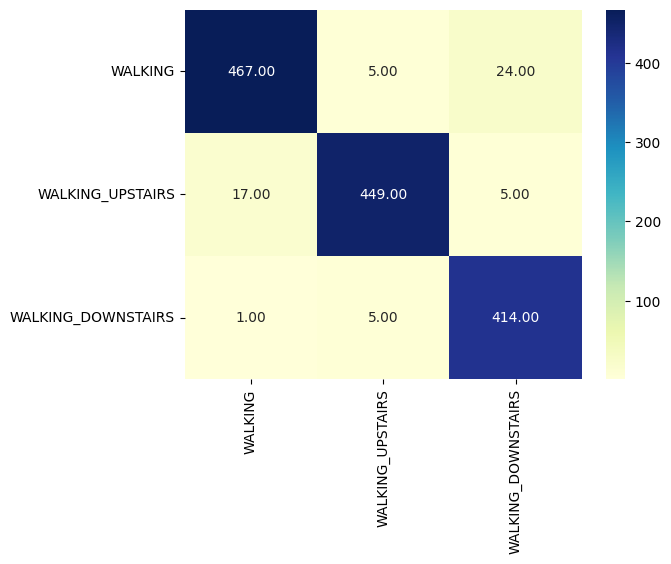

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 3

In [26]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                      

In [27]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 13s 131ms/step - loss: 1.0510 - accuracy: 0.4384 - val_loss: 0.9919 - val_accuracy: 0.5122
Epoch 2/10
26/26 [==============================] - 2s 59ms/step - loss: 0.9089 - accuracy: 0.5677 - val_loss: 0.7683 - val_accuracy: 0.6653
Epoch 3/10
26/26 [==============================] - 2s 66ms/step - loss: 0.6940 - accuracy: 0.6925 - val_loss: 0.3783 - val_accuracy: 0.8438
Epoch 4/10
26/26 [==============================] - 2s 63ms/step - loss: 0.2884 - accuracy: 0.8843 - val_loss: 0.0498 - val_accuracy: 0.9848
Epoch 5/10
26/26 [==============================] - 2s 58ms/step - loss: 0.0559 - accuracy: 0.9814 - val_loss: 0.0046 - val_accuracy: 0.9990
Epoch 6/10
26/26 [==============================] - 2s 59ms/step - loss: 0.0187 - accuracy: 0.9957 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - 2s 59ms/step - loss: 0.0103 - accuracy: 0.9976 - val_loss: 8.1223e-04 - val_accuracy: 1.0000
Epoch 8

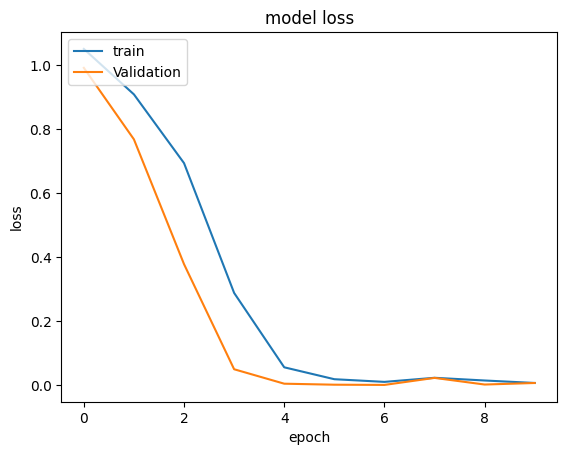

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

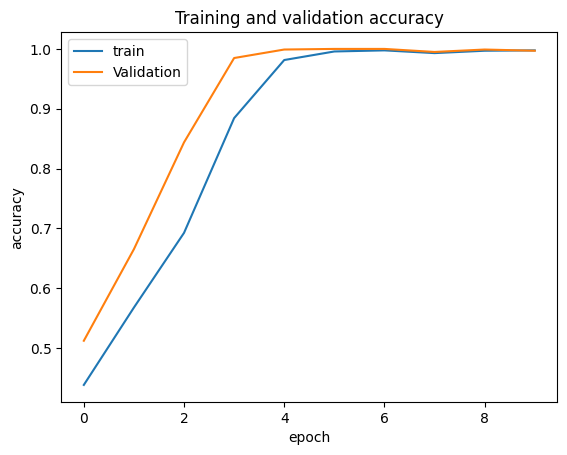

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 3s 14ms/step
[[470   0  26]
 [ 59 401  11]
 [  3   1 416]]
0.9279019466474405
0.9275486144167823
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       496
           1       1.00      0.85      0.92       471
           2       0.92      0.99      0.95       420

    accuracy                           0.93      1387
   macro avg       0.93      0.93      0.93      1387
weighted avg       0.93      0.93      0.93      1387



<Axes: >

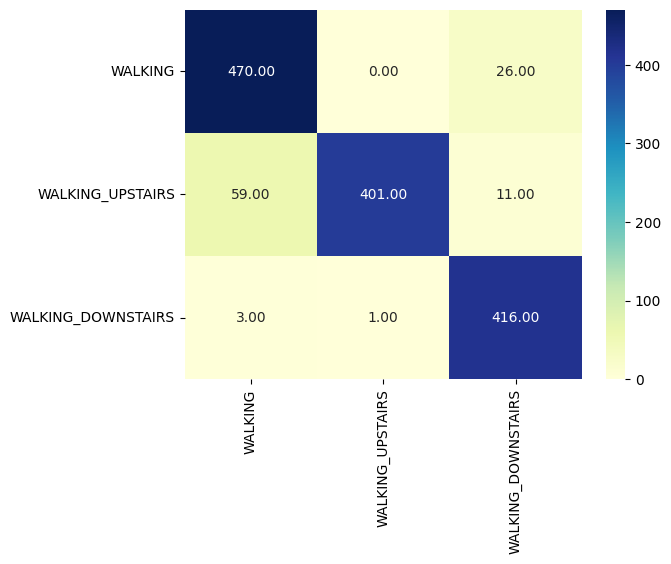

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 4

In [31]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                      

In [32]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 19s 182ms/step - loss: 1.0278 - accuracy: 0.4624 - val_loss: 0.9427 - val_accuracy: 0.5619
Epoch 2/10
26/26 [==============================] - 2s 81ms/step - loss: 0.8913 - accuracy: 0.5921 - val_loss: 0.7634 - val_accuracy: 0.6643
Epoch 3/10
26/26 [==============================] - 2s 87ms/step - loss: 0.6760 - accuracy: 0.7078 - val_loss: 0.4497 - val_accuracy: 0.8124
Epoch 4/10
26/26 [==============================] - 2s 83ms/step - loss: 0.3011 - accuracy: 0.8849 - val_loss: 0.1111 - val_accuracy: 0.9604
Epoch 5/10
26/26 [==============================] - 2s 80ms/step - loss: 0.0725 - accuracy: 0.9747 - val_loss: 0.0202 - val_accuracy: 0.9939
Epoch 6/10
26/26 [==============================] - 2s 80ms/step - loss: 0.0188 - accuracy: 0.9942 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - 2s 84ms/step - loss: 0.0080 - accuracy: 0.9979 - val_loss: 0.0016 - val_accuracy: 0.9990
Epoch 8/10


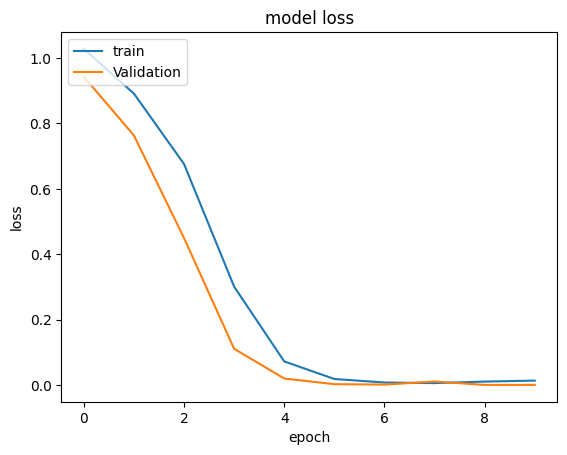

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

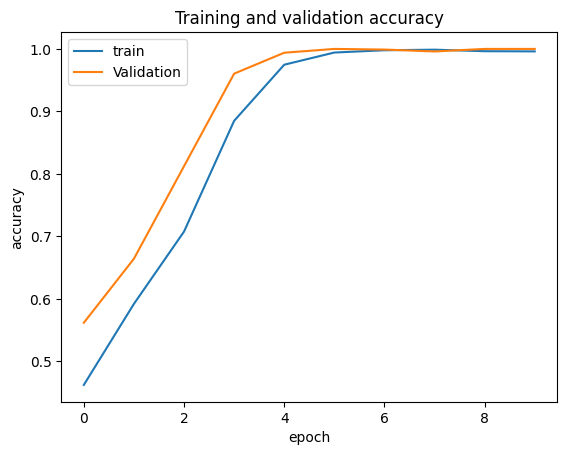

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 3s 19ms/step
[[477   4  15]
 [ 24 439   8]
 [  8   3 409]]
0.9552992069214131
0.955326360852416
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       496
           1       0.98      0.93      0.96       471
           2       0.95      0.97      0.96       420

    accuracy                           0.96      1387
   macro avg       0.96      0.96      0.96      1387
weighted avg       0.96      0.96      0.96      1387



<Axes: >

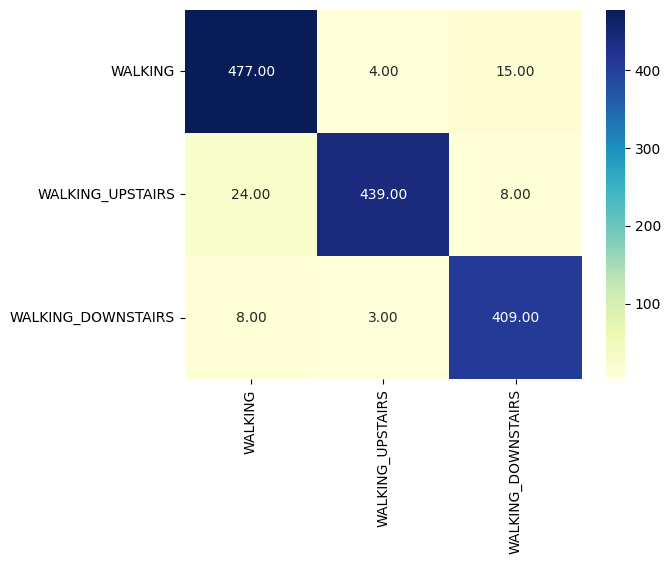

In [35]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU5

In [36]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 128, 256)          106752    
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_11 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_12 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                      

In [37]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
26/26 [==============================] - 22s 261ms/step - loss: 1.0357 - accuracy: 0.4600 - val_loss: 0.9730 - val_accuracy: 0.5527
Epoch 2/10
26/26 [==============================] - 3s 100ms/step - loss: 0.9200 - accuracy: 0.5543 - val_loss: 0.7798 - val_accuracy: 0.6542
Epoch 3/10
26/26 [==============================] - 3s 101ms/step - loss: 0.6764 - accuracy: 0.7123 - val_loss: 0.3658 - val_accuracy: 0.8631
Epoch 4/10
26/26 [==============================] - 3s 103ms/step - loss: 0.2203 - accuracy: 0.9227 - val_loss: 0.0385 - val_accuracy: 0.9888
Epoch 5/10
26/26 [==============================] - 3s 102ms/step - loss: 0.0398 - accuracy: 0.9848 - val_loss: 0.0075 - val_accuracy: 0.9990
Epoch 6/10
26/26 [==============================] - 3s 104ms/step - loss: 0.0162 - accuracy: 0.9942 - val_loss: 0.0098 - val_accuracy: 0.9970
Epoch 7/10
26/26 [==============================] - 3s 102ms/step - loss: 0.0040 - accuracy: 0.9994 - val_loss: 0.0184 - val_accuracy: 0.9959
Epoch

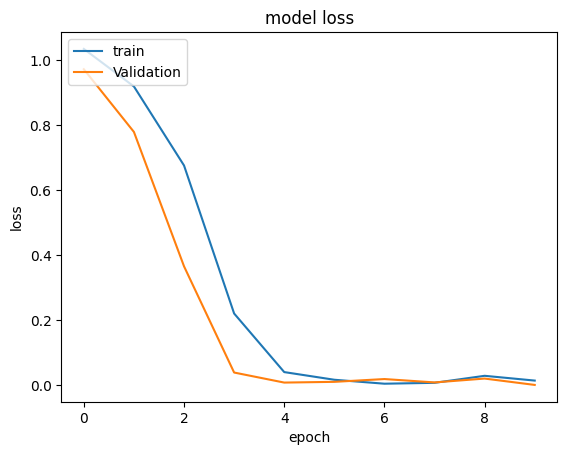

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

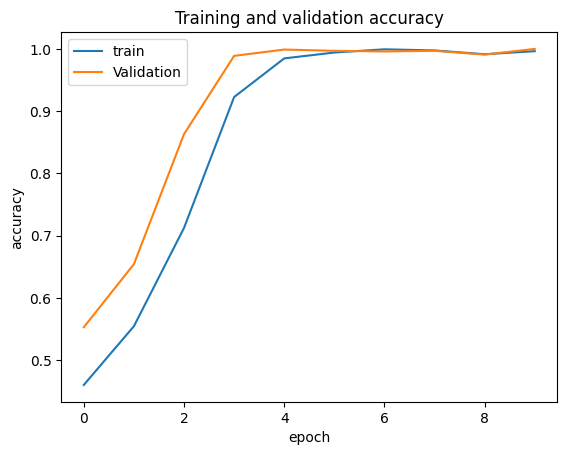

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 5s 26ms/step
[[470   0  26]
 [ 27 422  22]
 [  1   0 419]]
0.9452054794520548
0.945211375066888
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       496
           1       1.00      0.90      0.95       471
           2       0.90      1.00      0.94       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.95      0.95      0.95      1387



<Axes: >

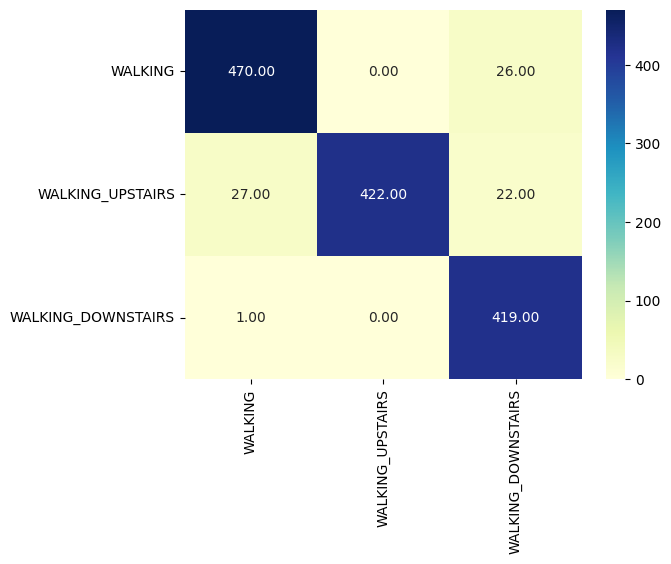

In [40]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')